In [17]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [3]:
df = pd.read_csv('./datasets/IRIS.csv')

In [4]:
features = df.drop(columns='species')
target = df[['species']]

preprocessor = ColumnTransformer(
    [
        ("MinmaxScaler", MinMaxScaler(), features.columns),
        ("OrdinalEncoder", OrdinalEncoder(), target.columns)
    ]
)

preprocessor.fit(df)

ColumnTransformer(transformers=[('MinmaxScaler', MinMaxScaler(),
                                 Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')),
                                ('OrdinalEncoder', OrdinalEncoder(),
                                 Index(['species'], dtype='object'))])

In [5]:
ord_enc = preprocessor.named_transformers_['OrdinalEncoder']
ord_enc.categories_[0]

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
df_copy = df.copy(deep=True)
df_copy[df_copy.columns] = preprocessor.transform(df_copy)

In [7]:
df_copy[:5]

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.222222,0.625000,0.067797,0.041667,0.0
1,0.166667,0.416667,0.067797,0.041667,0.0
2,0.111111,0.500000,0.050847,0.041667,0.0
3,0.083333,0.458333,0.084746,0.041667,0.0
4,0.194444,0.666667,0.067797,0.041667,0.0


In [8]:
X = df_copy.drop(columns=['species'])
y = df_copy['species']

In [9]:
# Definisikan model yang akan digunakan
model_params = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVM': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(algorithm='SAMME'),
    'GaussianNB': GaussianNB(),
    'RidgeClassifier': RidgeClassifier(),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
    'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
    'LGBMClassifier': LGBMClassifier(min_data_in_leaf=1, min_gain_to_split=0, verbose=-1),
    'LogisticRegression': LogisticRegression(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'VotingClassifier': VotingClassifier(estimators=[
        ('lr', LogisticRegression()), 
        ('rf', RandomForestClassifier()), 
        ('gnb', GaussianNB())
    ], voting='soft'),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'ComplementNB': ComplementNB()
}

# Daftar metrik yang ingin dihitung
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro'),
}

In [10]:
# List untuk menyimpan rata-rata hasil dan waktu pelatihan
average_results = []
cross_validation = 5

# Melatih semua model menggunakan cross-validation
for model_name, model in tqdm(model_params.items(), desc="Training Models", unit=" model"):
    cv_results = cross_validate(model, X, y, scoring=scoring, cv=cross_validation, return_train_score=False)
    # Rata-rata hasil cross-validation untuk metrik
    average_metric_result = {f'model': model_name}
    for metric_name in scoring.keys():
        average_metric_result[metric_name] = cv_results[f'test_{metric_name}'].mean()
    
    # Rata-rata waktu pelatihan
    average_metric_result['rerata_sekon_training'] = cv_results['fit_time'].mean()

    # Simpan hasil rata-rata
    average_results.append(average_metric_result)

# Konversi list hasil rata-rata ke dalam pandas DataFrame
df_average = pd.DataFrame(average_results)

Training Models: 100%|██████████| 19/19 [00:05<00:00,  3.46 model/s]


In [11]:
df_average.sort_values(by=['accuracy', 'rerata_sekon_training'], ignore_index=True, ascending=False)

,model,accuracy,precision,recall,rerata_sekon_training
0,QuadraticDiscriminantAnalysis,0.980000,0.980606,0.980000,0.002401
1,RandomForestClassifier,0.966667,0.970707,0.966667,0.124898
2,GradientBoostingClassifier,0.960000,0.962290,0.960000,0.271932
3,DecisionTreeClassifier,0.960000,0.962290,0.960000,0.004543
4,SVM,0.960000,0.963300,0.960000,0.002007
5,KNeighborsClassifier,0.960000,0.962290,0.960000,0.001593
6,XGBClassifier,0.953333,0.957374,0.953333,0.159800
7,AdaBoostClassifier,0.953333,0.957239,0.953333,0.061611
8,BaggingClassifier,0.953333,0.955017,0.953333,0.016990
9,GaussianNB,0.953333,0.958384,0.953333,0.002000


In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42
)

X_train.shape, X_valid.shape

((135, 4), (15, 4))

In [13]:
# Inisialisasi model QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

# Kombinasi parameter yang akan diuji oleh GridSearchCV
param_grid = {
    'reg_param': [0.0, 0.01, 0.1, 0.5, 0.9, 1.0],  # Nilai regularisasi
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],              # Toleransi untuk konvergensi
    'store_covariance': [True, False],            # Apakah menyimpan covariance matrices atau tidak
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=qda, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Melakukan GridSearch untuk menemukan parameter terbaik
grid_search.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=QuadraticDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'reg_param': [0.0, 0.01, 0.1, 0.5, 0.9, 1.0],
                         'store_covariance': [True, False],
                         'tol': [0.0001, 0.001, 0.01, 0.1]},
             scoring='accuracy', verbose=2)

In [14]:
# Cetak parameter terbaik yang ditemukan oleh GridSearch
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_}")

Best Parameters: {'reg_param': 0.0, 'store_covariance': True, 'tol': 0.0001}
Best Cross-validation Accuracy: 0.9800000000000001


In [15]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

# Menampilkan hasil klasifikasi
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         6
         2.0       1.00      1.00      1.00         3

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



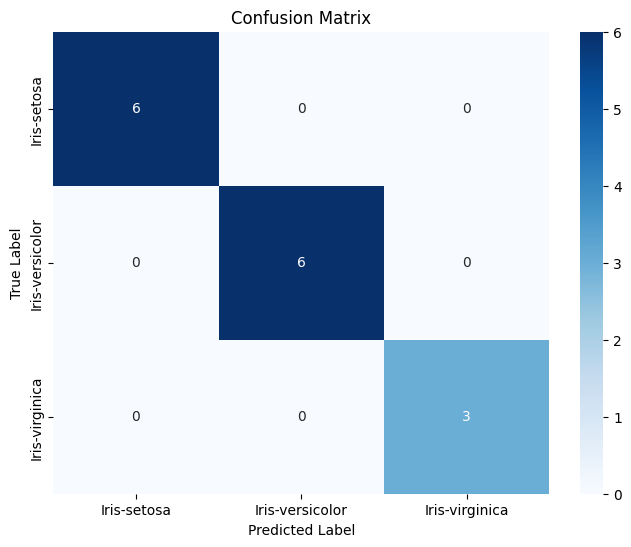

In [18]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=ord_enc.categories_[0], yticklabels=ord_enc.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
from collections import Counter

In [20]:
label_pred = ord_enc.inverse_transform(y_pred.reshape(-1,1)).ravel()
Counter(label_pred)

Counter({'Iris-versicolor': 6, 'Iris-setosa': 6, 'Iris-virginica': 3})